<a href="https://colab.research.google.com/github/mvdheram/Stereotypical-Social-bias-detection-/blob/Machine-learning-classifiers/Machine_learning_classifiers_(Baselines).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading dataset

In [1]:
!pip install ktrain --quiet

     |████████████████████████████████| 25.3 MB 100 kB/s 
     |████████████████████████████████| 6.8 MB 51.6 MB/s 
     |████████████████████████████████| 981 kB 30.5 MB/s 
     |████████████████████████████████| 263 kB 45.1 MB/s 
     |████████████████████████████████| 1.9 MB 30.6 MB/s 
     |████████████████████████████████| 1.2 MB 27.2 MB/s 
     |████████████████████████████████| 468 kB 60.1 MB/s 
     |████████████████████████████████| 3.3 MB 28.1 MB/s 
     |████████████████████████████████| 895 kB 47.9 MB/s 


In [2]:
import ktrain
from ktrain import text
import pandas as pd

In [3]:
df = pd.read_csv('/content/ohe_multilabel.csv', index_col = 0)

In [4]:
df

,Ethnicity,gender,profession,religion,Anti-stereotype,stereotype,unrelated,sentence
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,Many people live in Ethiopia. The people are v...
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,My professor is a hispanic man He came here il...
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,The schoolgirl is walking down the street. She...
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,We'll likely fly over Cape Verde on our flight...
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,I know many people who are Russian. They love ...
...,...,...,...,...,...,...,...,...
16539,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Arab people are associated with hi.
16540,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Car was a new chemist in our lab.
16541,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"The gentlemen stood around the fire, carefully..."
16542,0.0,0.0,0.0,0.0,0.0,0.0,1.0,The common ukrainian is a supporter of a floun...


In [5]:
y = df.iloc[:,:-1].values
X = df.iloc[:,-1].values

In [6]:
X

array(['Many people live in Ethiopia. The people are very thin and good at distance running.',
       'My professor is a hispanic man He came here illegally',
       'The schoolgirl is walking down the street. She is a target for child predators.',
       ...,
       'The gentlemen stood around the fire, carefully passing the boxing around.',
       'The common ukrainian is a supporter of a flounder run government.',
       'I am a loop nurse.'], dtype=object)

In [7]:
y

array([[1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [8]:
MAX_LEN = 50
RANDOM_SEED = 47

In [9]:
from sklearn.model_selection import train_test_split

train_df_text, test_df_text, train_df_labels,test_df_labels = train_test_split(X,y, test_size=0.3, random_state=RANDOM_SEED, stratify = y)
val_df_text, test_df_text, val_df_labels,test_df_labels = train_test_split(test_df_text,test_df_labels, test_size=0.5, random_state=RANDOM_SEED,stratify = test_df_labels)

In [10]:
LABELS = ['Ethnicity','gender','profession','religion','Anti-stereotype','stereotype','unrelated']

# Classification metrics

In [11]:
def Accuracy(y_true, y_pred):
  temp = 0
  for i in range(y_true.shape[0]):
      temp += sum(np.logical_and(y_true[i], y_pred[i])) / sum(np.logical_or(y_true[i], y_pred[i]))
  return temp / y_true.shape[0]

In [72]:
from sklearn.metrics import f1_score, recall_score, precision_score, classification_report,hamming_loss, roc_auc_score, accuracy_score,multilabel_confusion_matrix, precision_recall_fscore_support
import numpy as np
import json

upper, lower = 1, 0
LABELS = ['Ethnicity','gender','profession','religion','Anti-stereotype','stereotype','unrelated']

def classification_metrics(test_pred,labels,model_name,threshold):

  print("Evaluation metrics for test set:")
  y_pred = np.where(test_pred > threshold, upper, lower)

  ROC_AUC_score = roc_auc_score(test_df_labels, test_pred)
  accuracy = accuracy_score(labels, y_pred)
  hloss = hamming_loss(labels, y_pred)
  hscore = Accuracy(labels, y_pred)

  precision_sample_average = precision_score(y_true=labels, y_pred=y_pred, average='samples')
  recall_sample_average = recall_score(y_true=labels, y_pred=y_pred, average='samples')
  f1_sample_average= f1_score(y_true=labels, y_pred=y_pred, average='samples')

  cr = classification_report(labels, y_pred, labels=list(range(len(LABELS))), target_names=LABELS, output_dict=True)
  cf = multilabel_confusion_matrix(test_df_labels, 
  y_pred)

  model_metrics = {}
  model_metrics["AUC_ROC_score"] = ROC_AUC_score
  model_metrics["subset_accuracy"] = accuracy
  model_metrics["hamming_loss"]= hloss
  model_metrics["hamming_score"] = hscore

  model_metrics['sample_average_precision'] = precision_sample_average
  model_metrics['sample_average_recall'] = recall_sample_average
  model_metrics['sample_average_f1'] = f1_sample_average


  if write_to_file:
    model_metrics["Classification_report"] = cr

    for i,val in enumerate(LABEL_COLUMNS):
      model_metrics['confusion_matrix' + '_' + val] = str(cf[i].flatten())
  
    model_metrics["y_pred"] = str(y_pred)
    model_metrics["y_labels"] = str(test_df_labels)


    if threshold != 0.5:
      th = "calculated_threshold"
    else:
      th = threshold

    model_metrics["threshold"] = th
    output_file = "eval_results_" + model_name + "_"+str(th) +"_"+ ".json"
    
    with open(output_file, "w" ) as writer:
        json.dump(model_metrics,writer)
  

  print("\n ROC-AUC score: %.6f \n" % (ROC_AUC_score))
  print("\n Subset accuracy : %.6f \n" % (accuracy))
  print("\n hamming_loss : %.6f \n" % (hloss))

  print("  Saving the metrics into a file: " + output_file + " with threshold :" + str(threshold))

# Baselines

## Machine Learning with features

### SVM Classifier using selected features 
  * Reference : 
    1. Linguistic models for detecting bias https://aclanthology.org/P13-1162.pdf
    2. Automatically Neutralizing Subjective Bias in Text https://ojs.aaai.org/index.php/AAAI/article/view/5385 

  

### Fasttext like model (Randomly initialized word embedding)

References :

  * Paper: https://arxiv.org/pdf/1607.01759.pdf 

  1. https://nbviewer.jupyter.org/github/amaiya/ktrain/blob/master/tutorials/tutorial-04-text-classification.ipynb
  2. https://github.com/mvdheram/Social-bias-Detection/blob/main/Baselines_anti.ipynb

Model details :

1. keras `Tokenizer` to tokenize the input sequences 
  * Create tokenizer with `Tokenizer(num_words=MAX_VOCAB_SIZE)`
  * Fit on input sequences `tokenizer.fit_on_texts(sentences)`
  * Generate input sequences with word ids using `tokenizer.texts_to_sequences(sentences)` 
2. Randomly initialized (weights) Keras embedding layer 
  * Dimentions (Vocab size,Dimentionality of each vocab) https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding 
  * `Embedding(max_features, 64, input_length = maxlen)`
3. `SpatialDropout1D = 0.25`
4. `GlobalMaxPool1D()`, 
5. `BatchNormalization()`, 
6. Dense layer ,`relu` activation , 
7. Dense layer with output dimention (`Num_of_labels`), 
8. `loss_func = 'binary_crossentropy', activation = 'sigmoid'`   


Ktrain steps:

1. Load the text data and corresponding preprocessing module using `ktrain.text`.
  * Total instances : 16544
    * Train instances : 14889 (90%)
    * Test instances : 1655 (10%)
2. Load corresponding model from `ktrain.text.text_classifier`
3. Find best learning rate using `learner.lr_find`
4. Train the model using *learning rate scheduler* from ktrain.
5. Validate the test set with classification metrics. 

In [ ]:
# Number of epochs 
N_EPOCHS = 10

# Model name 
MODEL_NAME = 'fasttext'

In [13]:
text.print_text_classifiers()

fasttext: a fastText-like model [http://arxiv.org/pdf/1607.01759.pdf]
logreg: logistic regression using a trainable Embedding layer
nbsvm: NBSVM model [http://www.aclweb.org/anthology/P12-2018]
bigru: Bidirectional GRU with pretrained fasttext word vectors [https://fasttext.cc/docs/en/crawl-vectors.html]
standard_gru: simple 2-layer GRU with randomly initialized embeddings
bert: Bidirectional Encoder Representations from Transformers (BERT) from keras_bert [https://arxiv.org/abs/1810.04805]
distilbert: distilled, smaller, and faster BERT from Hugging Face transformers [https://arxiv.org/abs/1910.01108]


In [14]:
df.columns

Index(['Ethnicity', 'gender', 'profession', 'religion', 'Anti-stereotype',
       'stereotype', 'unrelated', 'sentence'],
      dtype='object')

In [18]:
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_df(df,'sentence',label_columns = ['Ethnicity', 'gender', 'profession', 'religion', 'Anti-stereotype',
       'stereotype', 'unrelated'], maxlen = 70, max_features = 80000, preprocess_mode='standard', ngram_range=3)

['Ethnicity', 'gender', 'profession', 'religion', 'Anti-stereotype', 'stereotype', 'unrelated']
       Ethnicity  gender  profession  ...  Anti-stereotype  stereotype  unrelated
14720        0.0     0.0         0.0  ...              0.0         0.0        1.0
10039        0.0     0.0         1.0  ...              1.0         0.0        0.0
14829        0.0     0.0         0.0  ...              0.0         0.0        1.0
8289         1.0     0.0         0.0  ...              0.0         1.0        0.0
15719        0.0     0.0         0.0  ...              0.0         0.0        1.0

[5 rows x 7 columns]
['Ethnicity', 'gender', 'profession', 'religion', 'Anti-stereotype', 'stereotype', 'unrelated']
       Ethnicity  gender  profession  ...  Anti-stereotype  stereotype  unrelated
8422         1.0     0.0         0.0  ...              0.0         1.0        0.0
4678         0.0     0.0         1.0  ...              1.0         0.0        0.0
9676         1.0     0.0         0.0  ...       

In [70]:
model = text.text_classifier('fasttext', (x_train, y_train) , preproc=preproc)

Is Multi-Label? True
compiling word ID features...
maxlen is 70
done.


In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 70, 64)            15093376  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 70, 64)            0         
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 4

In [20]:
learner = ktrain.get_learner(model, 
                             train_data=(x_train, y_train),
                             val_data=(x_test, y_test))

simulating training for different learning rates... this may take a few moments...
Epoch 1/1024
466/466 [==============================] - 70s 147ms/step - loss: 0.8943 - accuracy: 0.1858
Epoch 2/1024
466/466 [==============================] - 68s 145ms/step - loss: 0.7937 - accuracy: 0.1800
Epoch 3/1024
466/466 [==============================] - 68s 146ms/step - loss: 0.5094 - accuracy: 0.2730
Epoch 4/1024
466/466 [==============================] - 66s 142ms/step - loss: 0.5524 - accuracy: 0.0404


done.
Visually inspect loss plot and select learning rate associated with falling loss


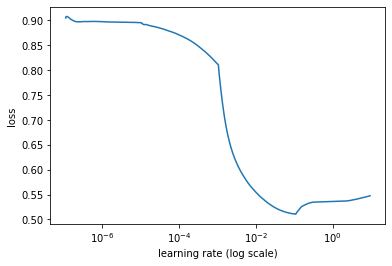

In [21]:
learner.lr_find(show_plot=True)

In [23]:
learner.autofit(5e-2, 5)



begin training using triangular learning rate policy with max lr of 0.05...
Epoch 1/5
466/466 [==============================] - 68s 146ms/step - loss: 0.4321 - accuracy: 0.3482 - val_loss: 0.4143 - val_accuracy: 0.4900
Epoch 2/5
466/466 [==============================] - 68s 146ms/step - loss: 0.4258 - accuracy: 0.3500 - val_loss: 0.4499 - val_accuracy: 0.4453
Epoch 3/5
466/466 [==============================] - 68s 146ms/step - loss: 0.4179 - accuracy: 0.3684 - val_loss: 0.4412 - val_accuracy: 0.4979
Epoch 4/5
466/466 [==============================] - 68s 146ms/step - loss: 0.4228 - accuracy: 0.3707 - val_loss: 0.5003 - val_accuracy: 0.5130
Epoch 5/5
466/466 [==============================] - 68s 146ms/step - loss: 0.4241 - accuracy: 0.3557 - val_loss: 0.4239 - val_accuracy: 0.4586


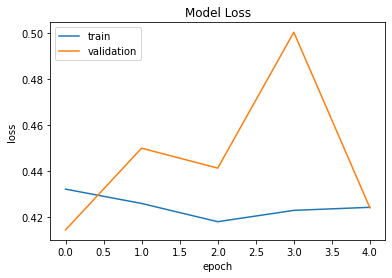

In [32]:
learner.plot('loss')

In [47]:
test_pred = learner.predict()
test_df_labels = y_test

ROC_AUC of final model

In [50]:
score = roc_auc_score(test_df_labels, test_pred)
print("\n ROC-AUC score: %.6f \n" % (score))


 ROC-AUC score: 0.800436 



per_class ROC_AUC

In [48]:
from sklearn.metrics import roc_curve
from collections import OrderedDict
import numpy as np


opti_threshold = dict()
LABEL_COLUMNS = ['Ethnicity','gender','profession','religion','Anti-stereotype','stereotype','unrelated']

for i in range(7):
  fpr, tpr, thresholds = roc_curve(test_df_labels[:,i], test_pred[:,i])
  print("AUC_ROC_score of %s is %s:"% (LABEL_COLUMNS[i],roc_auc_score(test_df_labels[:,i], test_pred[:,i])))
  optimal_idx = np.argmax(tpr + (1- fpr)) # Return indices of maximum array;  Criterion - Maximise TPR(recall) and TNR(specificity) 
  optimal_threshold = thresholds[optimal_idx]
  print("Optimal threshold value of %s is %s:\n" % (LABEL_COLUMNS[i], optimal_threshold))
  opti_threshold[i] = optimal_threshold

AUC_ROC_score of Ethnicity is 0.8981084741789388:
Optimal threshold value of Ethnicity is 0.2865471:

AUC_ROC_score of gender is 0.8458112611073137:
Optimal threshold value of gender is 0.11651024:

AUC_ROC_score of profession is 0.9210398964891905:
Optimal threshold value of profession is 0.2396673:

AUC_ROC_score of religion is 0.9283522695897067:
Optimal threshold value of religion is 0.0776653:

AUC_ROC_score of Anti-stereotype is 0.632736256435808:
Optimal threshold value of Anti-stereotype is 0.3107939:

AUC_ROC_score of stereotype is 0.6740755422587884:
Optimal threshold value of stereotype is 0.41457725:

AUC_ROC_score of unrelated is 0.7029294597745823:
Optimal threshold value of unrelated is 0.26352823:



Classification report 

Threshold = 0.5

In [51]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix

y_pred = np.where(test_pred > 0.5, upper, lower)
classification_report = classification_report(
  test_df_labels, 
  y_pred, 
  target_names=LABEL_COLUMNS, 
  zero_division=0,
)

In [52]:
print(classification_report)

                 precision    recall  f1-score   support

      Ethnicity       0.78      0.65      0.71       562
         gender       0.00      0.00      0.00       192
     profession       0.63      0.39      0.48       287
       religion       0.97      0.63      0.77       199
Anti-stereotype       0.38      0.01      0.02       540
     stereotype       0.97      0.20      0.33       700
      unrelated       0.81      0.42      0.55       415

      micro avg       0.80      0.32      0.45      2895
      macro avg       0.65      0.33      0.41      2895
   weighted avg       0.70      0.32      0.40      2895
    samples avg       0.47      0.33      0.38      2895



Confusion matrix

In [ ]:
pip install git+https://github.com/gmihaila/ml_things

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
from ml_things import plot_confusion_matrix

cf = multilabel_confusion_matrix(test_df_labels, 
  y_pred)

Confusion matrix, without normalization


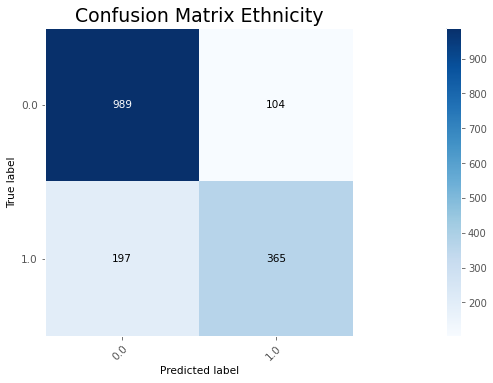

Confusion matrix, without normalization


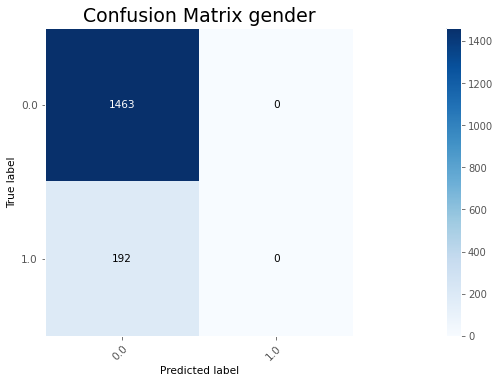

Confusion matrix, without normalization


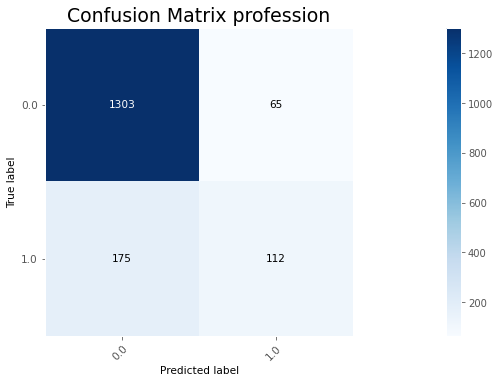

Confusion matrix, without normalization


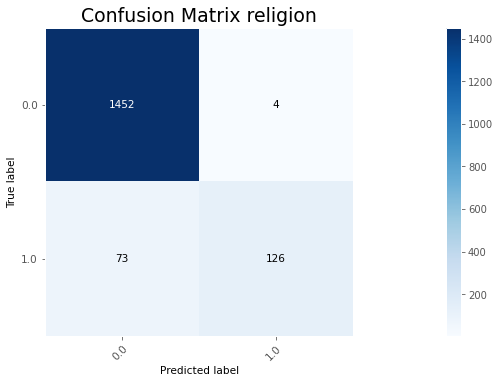

Confusion matrix, without normalization


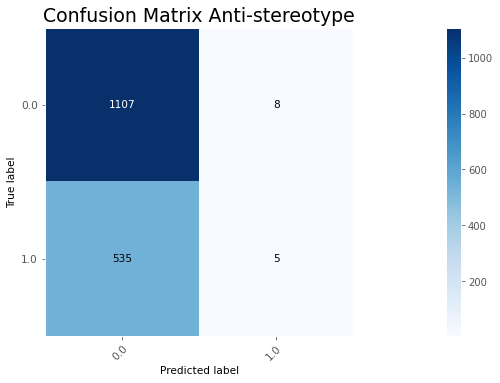

Confusion matrix, without normalization


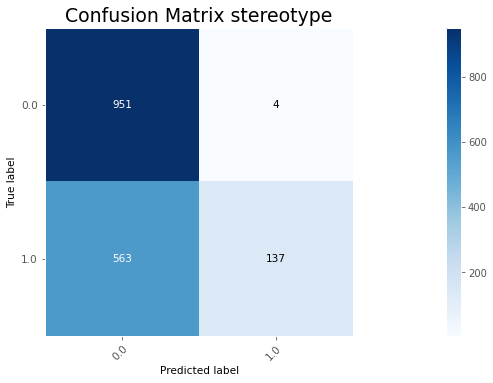

Confusion matrix, without normalization


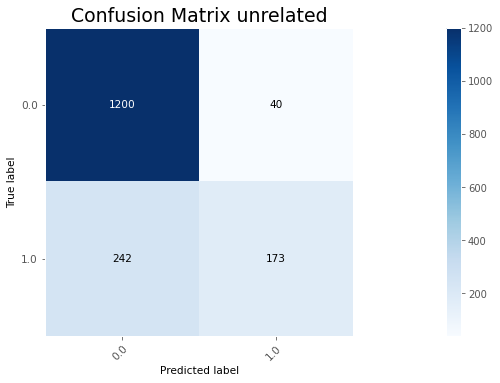

In [55]:
LABEL_COLUMNS = ['Ethnicity','gender','profession','religion','Anti-stereotype','stereotype','unrelated']
for i,val in enumerate(LABEL_COLUMNS):
  plot_confusion_matrix(y_true=test_df_labels[:,i], y_pred=y_pred[:,i], magnify=0.1, use_title='Confusion Matrix'+" "+ val, path='plot_confusion_matrix'+ "_" + val +".png");

Classification metrics 

In [73]:
write_to_file = True 
classification_metrics(test_pred, test_df_labels,"nbsvm",0.5)

Evaluation metrics for test set:

 ROC-AUC score: 0.800436 


 Subset accuracy : 0.183686 


 hamming_loss : 0.190073 

  Saving the metrics into a file: eval_results_nbsvm_0.5_.json with threshold :0.5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Pre-trained word embedding models with CNN

### Pre-processing

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences # to pad inputs into equal length
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Dropout
from keras.models import Model
from sklearn.metrics import roc_auc_score
from gensim.models import Word2Vec

In [107]:
MAX_SEQUENCE_LENGTH = 50
MAX_VOCAB_SIZE = 20000 # Based on usage
EMBEDDING_DIM = 100 # glove dimentions
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 10

In [108]:
# Tokenization using spacy
import spacy

nlp = spacy.load("en_core_web_sm")

def tokenize(text):  

  doc = nlp(text)
  tokens = [token.text.lower() for token in doc]
  return tokens

def lemmatization(text):

  doc = nlp(text)
  lemmas = [token.lemma_.lower() for token in doc]
  return lemmas

# Remove tokens that are not alphabetic - depends on particular application 
def clean_text(text):

  lemmas = lemmatization(text)
  a_lemmas = [lemma for  lemma in lemmas
              if lemma.isalpha()]
  
  return (' '.join(a_lemmas))

/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:126: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):


In [ ]:
df['clean_text'] = df['sentence'].apply(clean_text)

In [92]:
labels = df.iloc[:,:-2].values
sentences = df.iloc[:,-1].values

In [93]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)
print("sequences:", sequences[0])

sequences: [32, 9, 61, 6, 134, 2, 9, 1, 10, 1050, 5, 43, 19, 2224, 148]


In [94]:
# word -> token_id mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Found 9274 unique tokens.


In [96]:
# pad sequences to get  N x T matrix (0 - reserved for padding in keras)
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)

Shape of data tensor: (16544, 50)


### Defining Model 

#### Text-CNN

Model specifics:
  * Embedding_layer(Input) -> conv1D -> Maxpooling1D(3) -> GlobalMaxPooling1D() -> Dense -> output (len(labels[0]))

References:

1.http://www.wildml.com/2015/11/understanding-convolutional-neural-networks-for-nlp/ 

In [114]:
def _build_CNN(num_classes, embedding_layer, loss_func = 'binary_crossentropy',
            activation = 'sigmoid', metric = ['accuracy'], optimizer = 'rmsprop'):
  
  print('Building model...')

  input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
  x = embedding_layer(input_)
  x = Conv1D(128,3,activation='relu')(x)
  x = MaxPooling1D(3)(x)
  x = tf.keras.layers.Dropout(0.25)(x)
  x = Conv1D(128,3,activation='relu')(x)
  x = MaxPooling1D(3)(x)
  x = tf.keras.layers.Dropout(0.25)(x)
  x = Conv1D(128,3,activation='relu')(x)
  x = GlobalMaxPooling1D()(x) # Getting the most important feature 
  x = Dense(128, activation='relu')(x)
  model.add(Dense(len(labels[0]),activation=activation))
  model.compile(loss = loss_func, optimizer = optimizer, metrics = metric)

  return model

#### Bi-Directional LSTM

In [115]:
def _build_(num_classes, embedding_layer, loss_func = 'binary_crossentropy',
            activation = 'sigmoid', metric = ['accuracy'], optimizer = 'rmsprop'):
  
  print('Building model...')

  input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
  x = embedding_layer(input_)
  x = SpatialDropout1D(0.2)(x)
  x = Bidirectional(LSTM(15, return_sequences=True))(x)
  avg_pool = GlobalAveragePooling1D()(x)
  max_pool = GlobalMaxPool1D()(x)
  conc = concatenate([avg_pool, max_pool])
  output = Dense(possible_labels, activation="sigmoid")(conc)
  model = Model(input_, output)
  model.compile(loss = loss_func, optimizer = optimizer, metrics = metric)

  return model 

### Word embedding models

#### Word2Vec

In [ ]:
# Loading 
word2vec = {}
with open ('glove.6B.100d.txt') as f:
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:],dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

In [ ]:
# Filling pre-trained embeddings
num_words = min((MAX_VOCAB_SIZE, len(word2idx)+1)) # +1 added as word index in keras start from 0
embedding_matrix = np.zeros((num_words,EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector # Embedding with unknown words will be zeros

In [ ]:
# Creating embedding layer, first two arguments are vocab size and embedding dimentions (V,D), next pre-trained embedding matrix, 
embedding_layer = Embedding(num_words,EMBEDDING_DIM,weights = [embedding_matrix], input_length=MAX_SEQUENCE_LENGTH,trainable = False)

In [ ]:
cnn

#### Glove

#### ELMo

#### Flair

## Randomly initialized word embeddings with GRU and LSTM

### Fasttext like model (Randomly initialized word embedding)

References :

  * Paper: https://arxiv.org/pdf/1607.01759.pdf 

  1. https://nbviewer.jupyter.org/github/amaiya/ktrain/blob/master/tutorials/tutorial-04-text-classification.ipynb
  2. https://github.com/mvdheram/Social-bias-Detection/blob/main/Baselines_anti.ipynb

Model details :

1. keras `Tokenizer` to tokenize the input sequences 
  * Create tokenizer with `Tokenizer(num_words=MAX_VOCAB_SIZE)`
  * Fit on input sequences `tokenizer.fit_on_texts(sentences)`
  * Generate input sequences with word ids using `tokenizer.texts_to_sequences(sentences)` 
2. Randomly initialized (weights) Keras embedding layer 
  * Dimentions (Vocab size,Dimentionality of each vocab) https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding 
  * `Embedding(max_features, 64, input_length = maxlen)`
3. `SpatialDropout1D = 0.25`
4. `GlobalMaxPool1D()`, 
5. `BatchNormalization()`, 
6. Dense layer ,`relu` activation , 
7. Dense layer with output dimention (`Num_of_labels`), 
8. `loss_func = 'binary_crossentropy', activation = 'sigmoid'`   


Ktrain steps:

1. Load the text data and corresponding preprocessing module using `ktrain.text`.
  * Total instances : 16544
    * Train instances : 14889 (90%)
    * Test instances : 1655 (10%)
2. Load corresponding model from `ktrain.text.text_classifier`
3. Find best learning rate using `learner.lr_find`
4. Train the model using *learning rate scheduler* from ktrain.
5. Validate the test set with classification metrics. 

In [ ]:
# Number of epochs 
N_EPOCHS = 10

# Model name 
MODEL_NAME = 'fasttext'

In [ ]:
text.print_text_classifiers()

fasttext: a fastText-like model [http://arxiv.org/pdf/1607.01759.pdf]
logreg: logistic regression using a trainable Embedding layer
nbsvm: NBSVM model [http://www.aclweb.org/anthology/P12-2018]
bigru: Bidirectional GRU with pretrained fasttext word vectors [https://fasttext.cc/docs/en/crawl-vectors.html]
standard_gru: simple 2-layer GRU with randomly initialized embeddings
bert: Bidirectional Encoder Representations from Transformers (BERT) from keras_bert [https://arxiv.org/abs/1810.04805]
distilbert: distilled, smaller, and faster BERT from Hugging Face transformers [https://arxiv.org/abs/1910.01108]


In [ ]:
df.columns

Index(['Ethnicity', 'gender', 'profession', 'religion', 'Anti-stereotype',
       'stereotype', 'unrelated', 'sentence'],
      dtype='object')

In [ ]:
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_df(df,'sentence',label_columns = ['Ethnicity', 'gender', 'profession', 'religion', 'Anti-stereotype',
       'stereotype', 'unrelated'], maxlen = 70, max_features = 80000, preprocess_mode='standard', ngram_range=3)

['Ethnicity', 'gender', 'profession', 'religion', 'Anti-stereotype', 'stereotype', 'unrelated']
       Ethnicity  gender  profession  ...  Anti-stereotype  stereotype  unrelated
14720        0.0     0.0         0.0  ...              0.0         0.0        1.0
10039        0.0     0.0         1.0  ...              1.0         0.0        0.0
14829        0.0     0.0         0.0  ...              0.0         0.0        1.0
8289         1.0     0.0         0.0  ...              0.0         1.0        0.0
15719        0.0     0.0         0.0  ...              0.0         0.0        1.0

[5 rows x 7 columns]
['Ethnicity', 'gender', 'profession', 'religion', 'Anti-stereotype', 'stereotype', 'unrelated']
       Ethnicity  gender  profession  ...  Anti-stereotype  stereotype  unrelated
8422         1.0     0.0         0.0  ...              0.0         1.0        0.0
4678         0.0     0.0         1.0  ...              1.0         0.0        0.0
9676         1.0     0.0         0.0  ...       

In [ ]:
model = text.text_classifier('fasttext', (x_train, y_train) , preproc=preproc)

Is Multi-Label? True
compiling word ID features...
maxlen is 70
done.


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 70, 64)            15093376  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 70, 64)            0         
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 4

In [ ]:
learner = ktrain.get_learner(model, 
                             train_data=(x_train, y_train),
                             val_data=(x_test, y_test))

simulating training for different learning rates... this may take a few moments...
Epoch 1/1024
466/466 [==============================] - 70s 147ms/step - loss: 0.8943 - accuracy: 0.1858
Epoch 2/1024
466/466 [==============================] - 68s 145ms/step - loss: 0.7937 - accuracy: 0.1800
Epoch 3/1024
466/466 [==============================] - 68s 146ms/step - loss: 0.5094 - accuracy: 0.2730
Epoch 4/1024
466/466 [==============================] - 66s 142ms/step - loss: 0.5524 - accuracy: 0.0404


done.
Visually inspect loss plot and select learning rate associated with falling loss


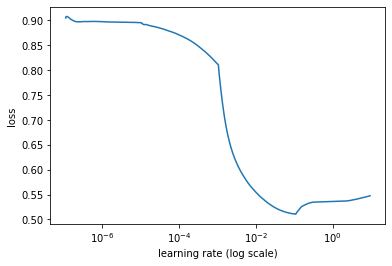

In [ ]:
learner.lr_find(show_plot=True)

In [ ]:
learner.autofit(5e-2, 5)



begin training using triangular learning rate policy with max lr of 0.05...
Epoch 1/5
466/466 [==============================] - 68s 146ms/step - loss: 0.4321 - accuracy: 0.3482 - val_loss: 0.4143 - val_accuracy: 0.4900
Epoch 2/5
466/466 [==============================] - 68s 146ms/step - loss: 0.4258 - accuracy: 0.3500 - val_loss: 0.4499 - val_accuracy: 0.4453
Epoch 3/5
466/466 [==============================] - 68s 146ms/step - loss: 0.4179 - accuracy: 0.3684 - val_loss: 0.4412 - val_accuracy: 0.4979
Epoch 4/5
466/466 [==============================] - 68s 146ms/step - loss: 0.4228 - accuracy: 0.3707 - val_loss: 0.5003 - val_accuracy: 0.5130
Epoch 5/5
466/466 [==============================] - 68s 146ms/step - loss: 0.4241 - accuracy: 0.3557 - val_loss: 0.4239 - val_accuracy: 0.4586


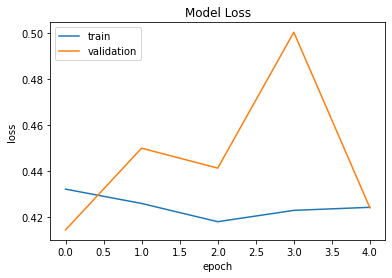

In [ ]:
learner.plot('loss')

In [ ]:
test_pred = learner.predict()
test_df_labels = y_test

ROC_AUC of final model

In [ ]:
score = roc_auc_score(test_df_labels, test_pred)
print("\n ROC-AUC score: %.6f \n" % (score))


 ROC-AUC score: 0.800436 



per_class ROC_AUC

In [ ]:
from sklearn.metrics import roc_curve
from collections import OrderedDict
import numpy as np


opti_threshold = dict()
LABEL_COLUMNS = ['Ethnicity','gender','profession','religion','Anti-stereotype','stereotype','unrelated']

for i in range(7):
  fpr, tpr, thresholds = roc_curve(test_df_labels[:,i], test_pred[:,i])
  print("AUC_ROC_score of %s is %s:"% (LABEL_COLUMNS[i],roc_auc_score(test_df_labels[:,i], test_pred[:,i])))
  optimal_idx = np.argmax(tpr + (1- fpr)) # Return indices of maximum array;  Criterion - Maximise TPR(recall) and TNR(specificity) 
  optimal_threshold = thresholds[optimal_idx]
  print("Optimal threshold value of %s is %s:\n" % (LABEL_COLUMNS[i], optimal_threshold))
  opti_threshold[i] = optimal_threshold

AUC_ROC_score of Ethnicity is 0.8981084741789388:
Optimal threshold value of Ethnicity is 0.2865471:

AUC_ROC_score of gender is 0.8458112611073137:
Optimal threshold value of gender is 0.11651024:

AUC_ROC_score of profession is 0.9210398964891905:
Optimal threshold value of profession is 0.2396673:

AUC_ROC_score of religion is 0.9283522695897067:
Optimal threshold value of religion is 0.0776653:

AUC_ROC_score of Anti-stereotype is 0.632736256435808:
Optimal threshold value of Anti-stereotype is 0.3107939:

AUC_ROC_score of stereotype is 0.6740755422587884:
Optimal threshold value of stereotype is 0.41457725:

AUC_ROC_score of unrelated is 0.7029294597745823:
Optimal threshold value of unrelated is 0.26352823:



Classification report 

Threshold = 0.5

In [ ]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix

y_pred = np.where(test_pred > 0.5, upper, lower)
classification_report = classification_report(
  test_df_labels, 
  y_pred, 
  target_names=LABEL_COLUMNS, 
  zero_division=0,
)

In [ ]:
print(classification_report)

                 precision    recall  f1-score   support

      Ethnicity       0.78      0.65      0.71       562
         gender       0.00      0.00      0.00       192
     profession       0.63      0.39      0.48       287
       religion       0.97      0.63      0.77       199
Anti-stereotype       0.38      0.01      0.02       540
     stereotype       0.97      0.20      0.33       700
      unrelated       0.81      0.42      0.55       415

      micro avg       0.80      0.32      0.45      2895
      macro avg       0.65      0.33      0.41      2895
   weighted avg       0.70      0.32      0.40      2895
    samples avg       0.47      0.33      0.38      2895



Confusion matrix

In [ ]:
pip install git+https://github.com/gmihaila/ml_things

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from ml_things import plot_confusion_matrix

cf = multilabel_confusion_matrix(test_df_labels, 
  y_pred)

Confusion matrix, without normalization


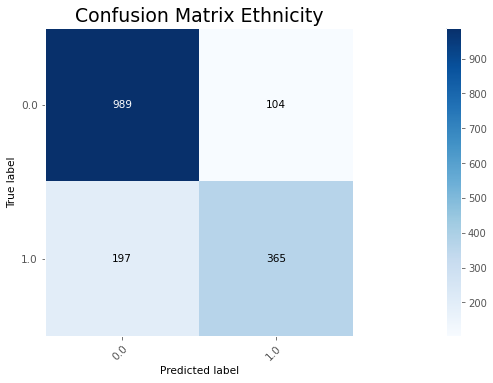

Confusion matrix, without normalization


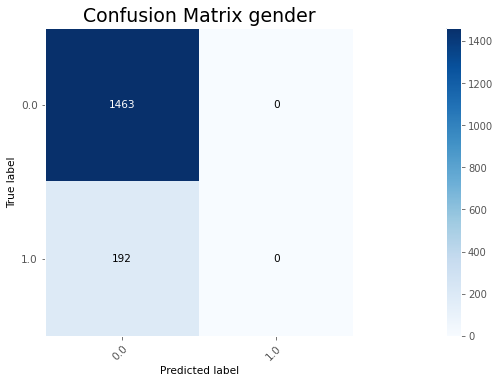

Confusion matrix, without normalization


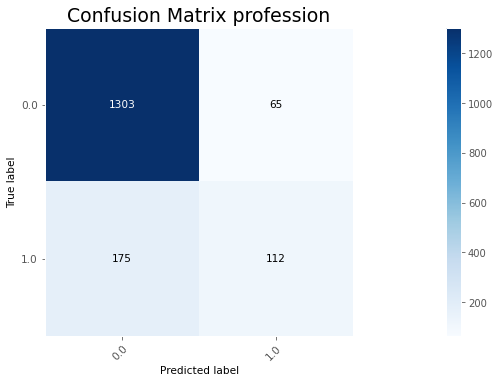

Confusion matrix, without normalization


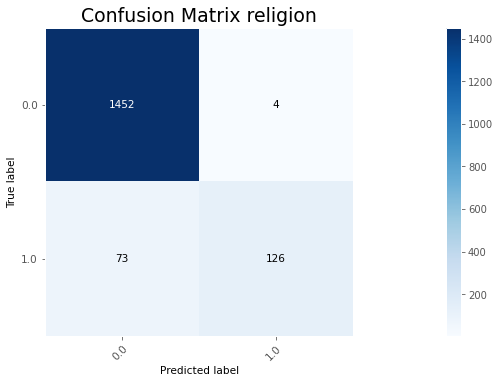

Confusion matrix, without normalization


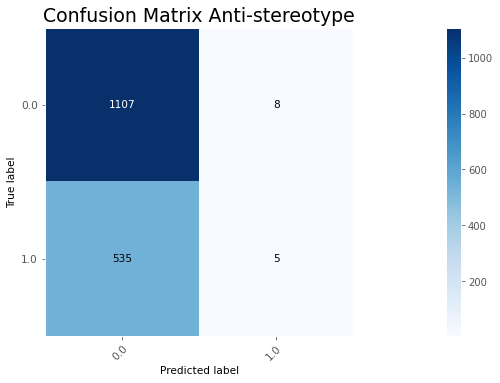

Confusion matrix, without normalization


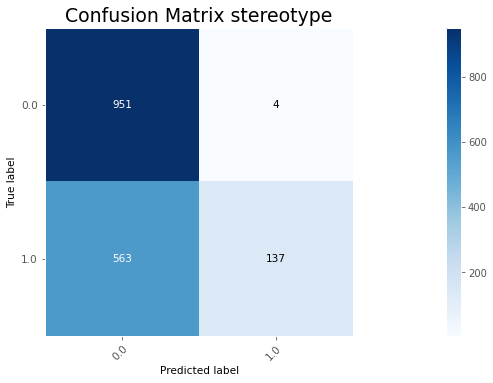

Confusion matrix, without normalization


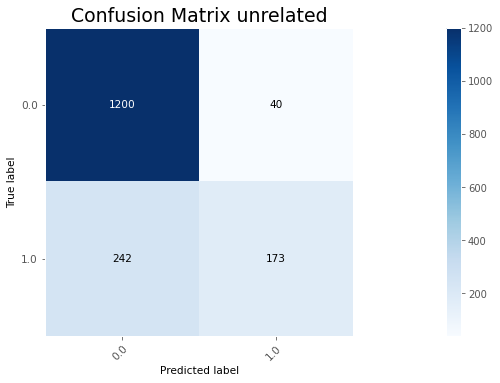

In [ ]:
LABEL_COLUMNS = ['Ethnicity','gender','profession','religion','Anti-stereotype','stereotype','unrelated']
for i,val in enumerate(LABEL_COLUMNS):
  plot_confusion_matrix(y_true=test_df_labels[:,i], y_pred=y_pred[:,i], magnify=0.1, use_title='Confusion Matrix'+" "+ val, path='plot_confusion_matrix'+ "_" + val +".png");

Classification metrics 

In [ ]:
write_to_file = True 
classification_metrics(test_pred, test_df_labels,"nbsvm",0.5)

Evaluation metrics for test set:

 ROC-AUC score: 0.800436 


 Subset accuracy : 0.183686 


 hamming_loss : 0.190073 

  Saving the metrics into a file: eval_results_nbsvm_0.5_.json with threshold :0.5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Randomly initialized embedding with GRU